# About

- `Title:` "Learning relevant features of data with multi-scale tensor networks"
- `Main Author:` E. Miles Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1801.00315)
- `Publish Date:` 31-12-2017
- `Reviewed Date:` 07-06-2021

## Citation

```latex
@article{stoudenmire2018learning,
  title={Learning relevant features of data with multi-scale tensor networks},
  author={Stoudenmire, E Miles},
  journal={Quantum Science and Technology},
  volume={3},
  number={3},
  pages={034003},
  year={2018},
  publisher={IOP Publishing}
}
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jax
import jax.numpy as jnp

In [3]:
from typing import Tuple, Optional, Iterable, Callable, List, Dict, Any, Union

In [4]:
import os
import csv

In [5]:
import functools
import itertools

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [7]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Utilities

The utilities below are used used in defferent parts of the main code.

In [8]:
def sliding_window(xs: List[Any], 
                   size: int, 
                   step: Optional[int]=2
                  ) -> List[List[Any]]:
    for i in range((len(xs)-size)//step + 1):
        yield xs[i*step:i*step+size]

In [9]:
print(*sliding_window(list(range(10)), size=3, step=2))

[0, 1, 2] [2, 3, 4] [4, 5, 6] [6, 7, 8]


## Powers of two

The code below is required to determine the appropriate size of the initial tree. The paper assumes that the numpber of leaves of the the tree is some power of two.

In [10]:
def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0

In [11]:
def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prec = 1 << (count-1)
    succ = 1 << count
    return prec, succ

quickly checking...

In [12]:
is_power_of_two(13), is_power_of_two(28*28), power_of_two(196)

(False, False, (128, 256))

## Some linear algebra

In [13]:
def ishermitian(A: jnp.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    """
    Check if the matrix is Hermitian.
    """
    return jnp.allclose(A, A.conj().T, rtol=rtol, atol=atol)

In [14]:
def ispsd(A: jnp.ndarray) -> bool:
    """
    Check if a matrix is positive semidefinite.
    """
    return jnp.all(jnp.linalg.eigvals(A) >= 0)

## Random matrices

In [15]:
def rand_unitary(dim: int) -> jnp.ndarray:
    """
    Random unitary matrix of dimention dim x dim
    http://home.lu.lv/~sd20008/papers/essays/Random%20unitary%20[paper].pdf
    """
    A = rand_mat(dim)
    Q,R = jnp.linalg.qr(A)
    r = jnp.diag(Q)
    L = jnp.diag(r/abs(r))
    return Q @ L

In [16]:
def rand_mat(dim1: int, dim2: Optional[int] = None) -> jnp.ndarray:
    """
    Genarate a random matrix of size (dim1, dim2).
    If no second dimention is provided, a square matrix
    of size (dim1, dim1) is returned.
    """
    if not dim2:
        dim2 = dim1
    key = jax.random.PRNGKey(31415)
    key, subkey = jax.random.split(key, 2)
    Re = jax.random.normal(key, shape=(dim1,dim2))
    Im = 1.j * jax.random.normal(subkey, shape=(dim1,dim2))
    return 2 * (Re + Im) - (1 + 1j)

In [17]:
def rand_hermitian(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A + A.conj().T

In [18]:
def rand_psd(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A @ A.conj().T

checking...

In [19]:
A = rand_unitary(30)
I = jnp.eye(30)
jnp.allclose(A @ A.conj().T, I, atol=1e-5)

DeviceArray(True, dtype=bool)

In [20]:
H = rand_hermitian(30)
ishermitian(H), ispsd(H)

(DeviceArray(True, dtype=bool), DeviceArray(False, dtype=bool))

In [21]:
P = rand_psd(30)
ispsd(P), ishermitian(P)

(DeviceArray(True, dtype=bool), DeviceArray(True, dtype=bool))

## Curve Plotting

In [22]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [23]:
def set_figsize(figsize=(3.5,2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [24]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [25]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5,2.5), axes=None,
         title=None):
    """Plot data points."""
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    axes.set_title(title)

## MNIST plotting

In [26]:
def show_img(img, axes=None, title=None, figsize=(1.5,1.5)):
    """Shows a single image."""
    axes = axes if axes else plt.gca()
    set_figsize(figsize)
    axes.imshow(img, cmap='Greys')
    axes.set_xticks([])
    axes.set_yticks([])
    if title:
        axes.set_title(title, fontsize=9)

In [27]:
def show_img_grid(imgs, titles):
    """Shows a grid of images."""
    n = int(jnp.ceil(len(imgs)**0.5))
    fig, axes = plt.subplots(n,n)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axes[i // n][i % n], title)

## Reading CSV helper

In [28]:
def read_csv(file_path: str, delimiter=','):
    """Read csv file"""
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        lines = [l for l in reader]
    return lines

---

# Loading MNIST dataset

In [29]:
def load_mnist(data_path: str) -> Union[Dict[str, jnp.ndarray]]:

    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = read_csv(train_data_path, delimiter=',')
    test_data = read_csv(test_data_path, delimiter=',')
               
    # creating data
    train_data = jnp.asarray(train_data, dtype=jnp.float32)
    test_data = jnp.asarray(test_data, dtype=jnp.float32)
   
    return {
        'train': {
            'images': train_data[:,1:],
            'labels': train_data[:,:1].astype(int),
        },
        'test': {
            'images': test_data[:,1:],
            'labels': test_data[:,:1].astype(int),
        }
    }

In [30]:
data = load_mnist('../data/mnist')

Quickly checking that data is loaded correctly by plotting a random image

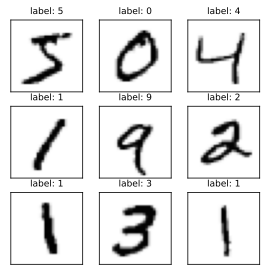

In [31]:
set_figsize((4.5,4.5))

show_img_grid(
    [data['train']['images'][i].reshape(28,28) for i in range(9)],
    [f"label: {data['train']['labels'][i].item()}" for i in range(9)],
)

# Process images

One needs to rescale images so the size of each image is a power of $2$. This is required for the algorithm to work and could be seen as a drawback. 

The are two options to rescale:
1. **Downscaling** the image may reduce the time required to train the tensor network model, but also has a drawback as it removes necessary information by reduction. 
2. **Upscaling** works in the opposit way. 
Which way to choose depends on a particular situation.

First, I determine the nearest powers of $2$ given the size of each image.

In [32]:
img_vec = data['train']['images'][0]  # take an image
size = jnp.sqrt(img_vec.size).astype(int)
size_l, size_h = power_of_two(size)   # returns nearest powers of 2 (low and high)

print(f'The nearest powers of two are: {size_l} and {size_h}.')

The nearest powers of two are: 16 and 32.


I decide to upscale the image to $32 \times 32$ pixels.

In [33]:
def resize(img_vec: jnp.ndarray, shape: Tuple[int,int]) -> jnp.ndarray:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='linear')
    return img.reshape(-1,1)

In [34]:
new_shape = (8,8)

In [35]:
# vectorized version of the resise
vresize = jax.vmap(functools.partial(resize, shape=new_shape))

In [36]:
train_images = jnp.squeeze(vresize(data['train']['images']))
test_images = jnp.squeeze(vresize(data['test']['images']))

In [37]:
train_images.shape, test_images.shape

((60000, 64), (10000, 64))

Checking if data is scaled properly by plotting random digits...

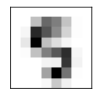

In [38]:
j = 41312
show_img(train_images[j].reshape(new_shape))

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text for details. We are interested in small $d$.

In [39]:
features = [
    lambda _: 1,
    lambda x: x,
#     lambda x: x**2
]

feature extraction...

In [40]:
train_data = jnp.stack([jax.vmap(jax.vmap(f))(train_images.T) for f in features])
test_data = jnp.stack([jax.vmap(jax.vmap(f))(test_images.T) for f in features])

In [41]:
train_data.shape, test_data.shape

((2, 64, 60000), (2, 64, 10000))

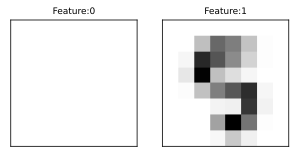

In [42]:
j = 41312     
img = train_data[:,:,j]

set_figsize((5,6))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}')

## Normalizing features

In [43]:
def normalize_along_axis(a: jnp.ndarray, 
                         ord: Optional[int] = 2,
                         axis: Optional[int] = -1) -> jnp.ndarray:
    z = jnp.atleast_1d(jnp.linalg.norm(a, ord, axis))
    z = z.at[jnp.where(z==0.0)].set(1.0)
    return a / jnp.expand_dims(z, axis)

train_data = normalize_along_axis(train_data, axis=0)
test_data = normalize_along_axis(test_data, axis=0)

checking on random sample...

In [44]:
sample_size = 100

key = jax.random.PRNGKey(31415)
key1, key2 = jax.random.split(key, 2)

for i in range(sample_size):
    m = jax.random.choice(key1, train_data.shape[0])
    n = jax.random.choice(key2, train_data.shape[2])
    assert jnp.allclose(train_data[:,m,n].T @ train_data[:,m,n], 1)
    assert jnp.allclose(test_data[:,m,n].T @ test_data[:,m,n], 1)

Checking again if images are correctly processed...

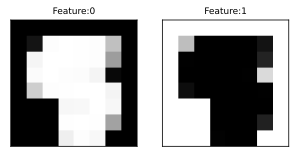

In [45]:
j = 41312     
img = train_data[:,:,j]

set_figsize((5,6))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}',
            )

## Rearranding axis for convenience

In [46]:
train_data = train_data.transpose(1,0,2)
test_data = test_data.transpose(1,0,2)

In [47]:
train_data.shape, test_data.shape

((64, 2, 60000), (64, 2, 10000))

# Learning the Tree Tensor Network

## The reduced covariance matrix and a truncation point

In [48]:
@jax.jit
def truncate_covariance(
    A: jnp.ndarray, 
    tol: Optional[float]=1e-3
    ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    to approximate the input covariance matrix.
    The truncation point satisfies the condition:
    sum(p)/trace(a) < eps.

    Input:
    ------
    A:      Matrix to be truncated (must be Hermitian).
    tol:    The allowed truncation error.

    Output:
    -------
    p:      The spectrum (eigenvalues) in increasing order.
    U:      The corresponding eigenvectors.
    idx:    The suggested index corresponding to the tol.
    """
    p, U = jnp.linalg.eigh(A)
    err = jnp.cumsum(p / jnp.trace(A))
    idx = jnp.searchsorted(err, tol)
    return p, U, idx

quickly checking

In [49]:
# random covariance matrix
A = rand_psd(100)

tols = [0.5**x for x in range(10)]
err = []
indices = []
for tol in tols:
    p,U,idx = truncate_covariance(A, tol=tol)
    Aᵟ = (U[:,idx:] * p[idx:]) @ U[:,idx:].conj().T
    Δ = jnp.abs(jnp.trace(A-Aᵟ))
    err.append(Δ)
    indices.append(idx)

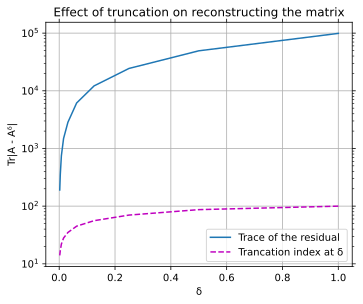

In [50]:
plot(tols, [err, indices], 
     xlabel='δ', ylabel='Tr|A - Aᵟ|', 
     legend=['Trace of the residual', 'Trancation index at δ'],
     figsize=(5.5,4.5),
     yscale='log',
     title='Effect of truncation on reconstructing the matrix'
)

## The protocol

To start, I introduce the tree data structure. This should accumulate the isometries as the algorithm keep building the tree recursively.

In [51]:
def truncate(A, tol=1e-3):
    """
    This is just a helper function to
    truncate the input tensor and reshape
    approprietely. Note, as I want to keep
    the heavy lifting in a jitted subroutine.
    The actual indexing is happening here.
    """
    m,n,*_ = A.shape
    C = A.reshape(m*n,-1)
    _,U,idx = truncate_covariance(C, tol)
    u,v = U.shape
    return U[:,idx:].reshape(m,n,-1)

In [52]:
Tree = Union[jnp.ndarray, List[jnp.ndarray]]

In [53]:
@jax.jit
def project(tree: Tree, isoms: Tree, *other: Iterable[Tree]) -> Iterable[Tree]:
    n = len(tree)
    idx = zip(*sliding_window(range(n), size=2, step=2))
    new_tree = jax.tree_multimap(
        lambda i,j,x: jnp.einsum('mj,nj,mnk->kj', tree[i], tree[j], x),
        *idx, 
        isoms,
    )
    if other:
        return project(new_tree, *other)
    else:
        return new_tree

In [54]:
def go(tree: Tree, tol: Optional[float]=1e-3) -> Tree:

    # getting the tree size
    n = len(tree)

    # precomputes all density matrices
    rhos = jax.tree_map(
        lambda x: jnp.einsum('ij,kj->ikj', x, x.conj()),
        tree
    )

    # pairwise reduced covariance
    idx = zip(*sliding_window(range(n), size=2, step=2))
    rho_ij = jax.tree_multimap(
        lambda i,j: (
            jnp.einsum(
                'ikj,mnj->imkn', 
                rhos[i], 
                rhos[j]
            )
        ),
        *idx
    )
    
    # truncated (approximated) isometries
    isometries = jax.tree_map(
        functools.partial(truncate, tol=tol), 
        rho_ij
    )
    
    return isometries

In [55]:
def build_tree(tree: Tree, 
               tol: Optional[float]=1e-3
              ) -> Tree:

    # getting the tree size
    n = len(tree)
    if n == 2:
        return
    
    assert is_power_of_two(n), 'The tree size must be a power of two'
    
    print(f'Tree width: {n}.')
    isoms = go(tree, tol=tol)
    yield isoms
    # defining a new tree
    new_tree = project(tree, isoms)
    yield from build_tree(new_tree, tol=tol)

In [61]:
# converting the ndarray to a list
phi_train = jax.tree_map(jnp.asarray, tuple(train_data))
phi_test = jax.tree_map(jnp.asarray, tuple(test_data))

In [63]:
tree_iterator = build_tree(phi_train, tol=1e-1)
tree_train, tree_test = itertools.tee(tree_iterator, 2)

All data after coarse graining.

In [64]:
train_labels = data['train']['labels']
test_labels = data['test']['labels']

train_ = project(phi_train, *tree_train)
test_ = project(phi_test, *tree_test)

Tree width: 64.
Tree width: 32.
Tree width: 16.
Tree width: 8.
Tree width: 4.


In [69]:
jax.tree_map(jnp.shape, train_), jax.tree_map(jnp.shape, test_)

(((49, 60000), (120, 60000)), ((49, 10000), (120, 10000)))

# Classifying digits

Below I want to compare my implementation of CGD to Sklearn Logistic model. Start with Logistic regression.

In [ ]:
i,j,n = train_data.shape
k,l,m = test_data.shape

assert i==k and j==l, 'Data shapes mismatch'

X_train = train_data.reshape(i*j,n).T
X_test = test_data.reshape(k*l,m).T

y_train = np.argwhere(train_labels==.99)[:,1]  # need to convert it back as Sklearn require raw labels
y_test = np.argwhere(test_labels==.99)[:,1]    # same here

In [ ]:
X_train.shape

In [ ]:
model = LogisticRegression(multi_class='ovr', solver='newton-cg')  # the CGD classifier is also OvA
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(f"Classification report for classifier {model}:\n\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

In [ ]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

In [ ]:
# # Plot normalized confusion matrix
# fig, ax = plt.subplots(figsize=(12, 12))
# disp = metrics.plot_confusion_matrix(
#     model, X_test, y_test, 
#     display_labels=np.arange(10),
#     cmap=plt.cm.Blues, 
#     ax=ax,
#     normalize='true')
# disp.ax_.set_title(f'Accuracy (Tree TN Compression): {metrics.accuracy_score(y_test, y_pred)}')
# plt.show()

# Training on the original dataset for reference

Below I want to see how much 'information' is lost after the coarse graining. For this, I train the same logistic regression classifier as above on the full dataset.

In [ ]:
X_train = train_images
X_test = test_images

In [ ]:
X_train.shape

In [ ]:
model_orig = LogisticRegression(multi_class='ovr', solver='newton-cg')  # same again, CGD is OvA and I want direct comparison
model_orig.fit(X_train, y_train)

In [ ]:
y_pred_orig = model_orig.predict(X_test)
print(f"Classification report for classifier {model}:\n\n"
      f"{metrics.classification_report(y_test, y_pred_orig)}\n")

In [ ]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred_orig)}\n')

# My conjugate gradient method implementation

I want to follow the paper as close as possible (and also learn something along the line). So, I have decided to implement a custom conjugate gradient descent algorithm that the paper is using as well.

In [ ]:
def conjugate_gradient(A, b, tol=1e-6):
    x = np.ones_like(b)
    r = A @ x - b
    d = -r
    while True:
        r2 = r @ r
        if np.sqrt(r2) < tol:
            break
        Ad = A @ d
        alpha = r2 / (d @ Ad)
        x = x + alpha * d
        r = r + alpha * Ad
        beta = r @ r / r2
        d = -r + beta * d
    return x

Testing it on a randomly generated dataset.

In [ ]:
n = 1000

np.random.seed(0)
A = np.random.normal(size=(n,n))
A = A.T @ A

# below are the requirements of the CGD algorithm.
assert ispsd(A), 'The matrix is not PSD'
assert ishermitian, 'The matrix is not Hermitian'    

b = np.random.rand(n)
%time x = conjugate_gradient(A, b)
np.allclose(A @ x, b, atol=1e-5)

# Train a classifier for each digit separately using CGD

In [ ]:
i,j,n = train_data.shape
k,l,m = test_data.shape

assert i==k and j==l, 'Data shapes mismatch'

X_train = train_data.reshape(i*j,n).T
X_test = test_data.reshape(k*l,m).T

y_train = np.argwhere(train_labels==.99)[:,1]
y_test = np.argwhere(test_labels==.99)[:,1]

In [ ]:
def clf_build(X, y):
    """
    Train a OvA classifier.
    """
    # getting the shape
    m,n = X.shape

    # assumed number of digits in the dataset
    n_digits = 10
    
    # storing weights
    W = np.zeros(shape=(n_digits,n+1), dtype=np.double)
    
    # adding bias term
    X_ = np.ones(shape=(m,n+1), dtype=np.double)
    X_[:,1:] = X

    # optimize the weights for each digit
    for digit in np.arange(n_digits):
        y_ = np.where(y != digit, 0.01, 0.99)
        # train cgd with square loss
        Z = X_.T @ X_
        q = X_.T @ y_
        W[digit,:] = conjugate_gradient(Z,q)
    # returns a set of parameters n_classes x n_features
    return W

def clf_predict(W, X):
    # resizing the arrray if one sample provided
    if X.ndim == 1:
        X = X[np.newaxis,:]
    # getting the shape
    m,n = X.shape
    # assumed number of digits in the dataset
    n_digits = 10
    # adding bias term
    X_ = np.ones(shape=(m,n+1), dtype=np.double)
    X_[:,1:] = X
    # stores predictions
    y_pred = np.zeros(shape=(m, n_digits), dtype=np.double)
    for digit in np.arange(n_digits):
        y_pred[:,digit] = X_ @ W[digit,:]
    return np.argmax(y_pred, axis=1)

In [ ]:
W = clf_build(X_train, y_train)
y_pred = clf_predict(W, X_test)

We can now also check a single sample...

In [ ]:
print(f'Classification report for classifier {model}:\n\n'
      f'{metrics.classification_report(y_test, y_pred)}\n')

In [ ]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

# Sandbox

## Brute force method (easy to understand)

In [ ]:
np.random.seed(0)
phi_rand = np.random.rand(3, 196, 1000)

In [ ]:
from timeit import default_timer as timer

def exec_time(tic, toc):
   diff_time = toc - tic
   ms = diff_time
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print('Execution Time: ' + f'{h:02d}:{m:02d}:{s:02d}:{ms:.4f}')

In [ ]:
l,r = 8,9
u,v,w = phi_rand.shape

tic = timer()

rho1 = np.zeros([u,u,u,u])
for j in range(w):
    left = np.einsum('ik,ik', phi_rand[:,:l,j], phi_rand[:,:l,j].conj())
    right = np.einsum('ik,ik', phi_rand[:,r+1:,j], phi_rand[:,r+1:,j].conj())

    # i   m
    # |   |
    # +---+
    # |   |
    # +---+
    # |   |
    # k   n

    for i in range(u):
        for k in range(u):
            for m in range(u):
                for n in range(u):
                    rho1[i,k,m,n] += left * right * phi_rand[i,l,j] * phi_rand[m,l,j].conj() * phi_rand[k,r,j] * phi_rand[n,r,j].conj()

toc = timer()
time1 = toc-tic

exec_time(tic,toc)

## Same as above, but using vectorization

In [ ]:
tic = timer()

u,v,w = phi_rand.shape

l,r = 8,9

# computes all density matrices for each j
rho2 = np.einsum('ilj,klj->iklj', phi_rand, phi_rand.conj())
# contraction of all parts to the left of the pointer (i.e. l)
left = np.einsum('ikj,ikj->j', phi_rand[:,:l,:], phi_rand[:,:l,:].conj())
# contraction all parts to the right of the pointer (i.e. r+1)
right = np.einsum('ikj,ikj->j', phi_rand[:,r+1:,:], phi_rand[:,r+1:,:].conj())
# reduced density matrix for the window
rho2 = np.einsum('ikj,mnj->imknj', rho2[:,:,l,:], rho2[:,:,r,:])
# scaled by left and right
rho2 = np.einsum('...j,...j,...j', rho2, left, right)

toc = timer()
time2 = toc-tic

exec_time(tic,toc)

## Checking that the results are the same

In [ ]:
np.allclose(rho1, rho2)

## Time gain

In [ ]:
time1 / time2

In [ ]:
  def body_fun(value):
    x, r, gamma, p, k = value
    Ap = A(p)
    alpha = gamma / _vdot(p, Ap)
    x_ = x + alpha * p
    r_ = r - alpha * Ap
    z_ = M(r_)
    gamma_ = _vdot(r_, z_)
    beta_ = gamma_ / gamma
    p_ = z_ + beta_ * p
    return x_, r_, gamma_, p_, k + 1